In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
#!pip install tensorflow==2.5.0

In [3]:
import tensorflow as tf
print(tf.__version__)

# !pip install -q tensorflow-datasets

import tensorflow_datasets as tfds
imdb, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)

2021-09-09 20:08:27.799441: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-09-09 20:08:27.799464: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


2.5.0


2021-09-09 20:08:30.319512: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-09-09 20:08:30.319532: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-09-09 20:08:30.319549: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (prashant-thinkpad): /proc/driver/nvidia/version does not exist
2021-09-09 20:08:30.319744: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
import numpy as np

train_data, test_data = imdb['train'], imdb['test']

training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []

for s, l in train_data:
    # training_sentences.append(str(s.numpy()))
    # training_labels.append(l.tonumpy())
    training_sentences.append(s.numpy().decode('utf-8'))
    training_labels.append(l.numpy())

for s, l in test_data:
#     testing_sentences.append(str(s.numpy()))
#     testing_labels.append(l.tonumpy())
    testing_sentences.append(s.numpy().decode('utf-8'))
    testing_labels.append(l.numpy())

training_labels = np.array(training_labels)
testing_labels = np.array(testing_labels)

2021-09-09 20:08:30.454807: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-09-09 20:08:30.477361: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 1999965000 Hz


In [5]:
vocab_size = 10000
embedding_dim = 16
max_length = 120
trunc_type = 'post'
oov_tok = '<OOV>'

In [6]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [7]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences, maxlen = max_length, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen = max_length)

In [8]:
reverse_word_index = {v:k for k,v in word_index.items()}

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_review(padded[1]))
print()
print(training_sentences[1])

? ? ? ? ? ? ? ? i have been known to fall asleep during films but this is usually due to a combination of things including really tired being warm and comfortable on the <OOV> and having just eaten a lot however on this occasion i fell asleep because the film was rubbish the plot development was constant constantly slow and boring things seemed to happen but with no explanation of what was causing them or why i admit i may have missed part of the film but i watched the majority of it and everything just seemed to happen of its own <OOV> without any real concern for anything else i cant recommend this film at all

I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. The plot development was constant. Constantly slow and boring. Things seemed to happen, but with no explanation of wha

In [9]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 16)           160000    
_________________________________________________________________
conv1d (Conv1D)              (None, 116, 128)          10368     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 24)                3096      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 173,489
Trainable params: 173,489
Non-trainable params: 0
_________________________________________________________________


In [10]:
model.compile(loss='binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 16)           160000    
_________________________________________________________________
conv1d (Conv1D)              (None, 116, 128)          10368     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 24)                3096      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 173,489
Trainable params: 173,489
Non-trainable params: 0
_________________________________________________________________


In [12]:
num_epochs = 50
history = model.fit(padded, training_labels, epochs = num_epochs, validation_data = (testing_padded, testing_labels))

Epoch 1/50
782/782 [==============================] - 9s 9ms/step - loss: 0.4859 - accuracy: 0.7507 - val_loss: 0.3671 - val_accuracy: 0.8376
Epoch 2/50
782/782 [==============================] - 5s 7ms/step - loss: 0.2921 - accuracy: 0.8768 - val_loss: 0.3705 - val_accuracy: 0.8374
Epoch 3/50
782/782 [==============================] - 7s 9ms/step - loss: 0.1820 - accuracy: 0.9318 - val_loss: 0.4004 - val_accuracy: 0.8388
Epoch 4/50
782/782 [==============================] - 6s 8ms/step - loss: 0.0963 - accuracy: 0.9684 - val_loss: 0.5035 - val_accuracy: 0.8309
Epoch 5/50
782/782 [==============================] - 6s 8ms/step - loss: 0.0418 - accuracy: 0.9892 - val_loss: 0.6290 - val_accuracy: 0.8299
Epoch 6/50
782/782 [==============================] - 7s 8ms/step - loss: 0.0145 - accuracy: 0.9972 - val_loss: 0.7465 - val_accuracy: 0.8248
Epoch 7/50
782/782 [==============================] - 7s 8ms/step - loss: 0.0044 - accuracy: 0.9994 - val_loss: 0.8749 - val_accuracy: 0.8232
Epoch 

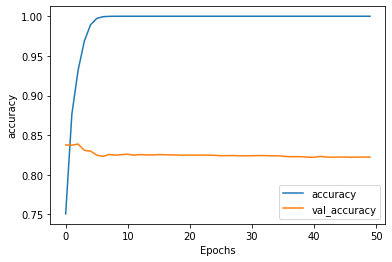

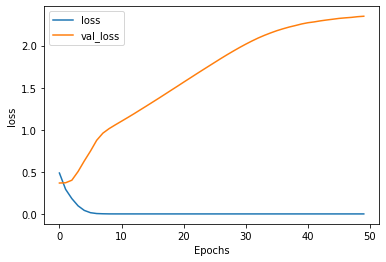

In [13]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')